<a href="https://colab.research.google.com/github/harnalashok/DataVisualization/blob/master/umap_tutorial_on_100_dimensional_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 13th June, 2022
# My folder: C:\Users\Ashok\OneDrive\Documents\tps_2021
# Data source: https://www.kaggle.com/competitions/tabular-playground-series-sep-2021/overview
# Reference: https://www.kaggle.com/code/bextuychiev/beautiful-umap-tutorial-on-100-dimensional-data/notebook

# Setup

In [ ]:
# 1.0 Install umap
!pip install umap-learn


In [ ]:
# 1.1 Install plot utility of umap
!pip install umap-learn[plot]

In [5]:
# 1.2 Call libraries
import numpy as np
import pandas as pd

# 1.2.1 Plotting related
import umap
import umap.plot  # pip install umap-learn[plot]
import matplotlib.pyplot as plt


# 1.2.2 Data processing related
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler


# 1.2.3 Miscelleneous
import warnings, os, time,gc
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

In [6]:
# 1.3 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
# 1.4 Mount google drive at /content
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction

# What is UMAP?

UMAP is a [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) algorithm and a powerful data analysis tool. It is similar to PCA (Principal Component Analysis) in terms of speed and resembles t-SNE to reduce dimensionality while preserving as much information of the dataset as possible. Before the UMAP algorithm was introduced in 2018, PCA and tSNE had two most significant flaws:

1) PCA was very fast at the cost of losing finer details of the data after the reduction<br>
2) t-SNE was extremely slow even though it preserves the underlying structure of the data.

Consider now a [dataset from Kaggle](https://www.kaggle.com/competitions/tabular-playground-series-sep-2021/overview).

In [8]:
# 2.0 Location of data folder on gdrive:
datapath = "/content/drive/MyDrive/Colab_data_files/tps_2021/"
os.chdir(datapath)
os.listdir()

['train_june2021.csv.zip', 'train_sep2021.csv.zip', 'readme.txt']

In [9]:
# 2.1 Read Sep-2021 data. It has binary classification
#       Drop 'id' column
start = time.time()
tps = pd.read_csv(datapath + "train_sep2021.csv.zip")
tps.drop(columns = ["id"], inplace = True)
end = time.time()
print((end-start)/60)    # Takes about 60seconds

0.999112872282664


In [11]:
# 2.2 From the data it appears that there is not scope
#      to change datatypes
tps.head()
# 2.3 Data shape
tps.shape   # (957919, 119)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0.10859,0.00431,-37.56600,0.01736,0.28915,-10.25100,135.12000,168900.00000,399240000000000.00000,86.48900,...,-12.22800,1.74820,1.90960,-7.11570,4378.80000,1.20960,861340000000000.00000,140.10000,1.01770,1
1,0.10090,0.29961,11822.00000,0.27650,0.45970,-0.83733,1721.90000,119810.00000,3874100000000000.00000,9953.60000,...,-56.75800,4.16840,0.34808,4.14200,913.23000,1.24640,7575100000000000.00000,1861.00000,0.28359,0
2,0.17803,-0.00698,907.27000,0.27214,0.45948,0.17327,2298.00000,360650.00000,12245000000000.00000,15827.00000,...,-5.76880,1.20420,0.26290,8.13120,45119.00000,1.17640,321810000000000.00000,3838.20000,0.40690,1
3,0.15236,0.00726,780.10000,0.02518,0.51947,7.49140,112.51000,259490.00000,77814000000000.00000,-36.83700,...,-34.85800,2.06940,0.79631,-16.33600,4952.40000,1.17840,4533000000000.00000,4889.10000,0.51486,1
4,0.11623,0.50290,-109.15000,0.29791,0.34490,-0.40932,2538.90000,65332.00000,1907200000000000.00000,144.12000,...,-13.64100,1.52980,1.14640,-0.43124,3856.50000,1.48300,-8991300000000.00000,NaN,0.23049,1


(957919, 119)

In [12]:
# 2.4 Here is another sample of 10 columns
tps.head().sample(10, axis=1)    # Sample of 10 columns

,f105,f91,f80,f22,f35,f84,f96,f44,f87,f19
0,0.28801,-0.00558,-0.00108,1.53970,10906000000000000.00000,5308500.00000,7768.90000,5.93250,53.39800,26.86700
1,0.34030,0.46843,0.25410,1.39510,30794000000000000.00000,32800.00000,7343.70000,2.07970,44.05100,4.64040
2,0.08488,0.49459,0.26026,2.00540,58491000000000.00000,1476600.00000,47.91500,5.34300,2.37310,1.95260
3,0.26071,0.40778,0.37283,2.55980,-92992000000000.00000,6485700.00000,12011.00000,15.88300,34.05600,8.00300
4,0.23825,0.47912,0.08569,3.42250,10125000000000000.00000,102100.00000,197.47000,NaN,58.56600,NaN


The Kaggle TPS September dataset contains ~1M rows and ~120 features with a binary target. They are all numerical.

Let's see if UMAP can discover structure in this dataset.

In [13]:
# 2.5 Split data into predictors and target
X, y = tps.drop("claim", axis=1), tps[["claim"]].values.flatten()

## PCA on data

In [11]:
%%time
# 3.0 First remove any missing values to perform
#     PCA/t-sne/umap. We take variance
#     threshold = 0.90 as we need to do 
#     just plotting and not estimating
#     Takes: 50seconds 

pipe = make_pipeline(
                      SimpleImputer(strategy="mean"),
                      StandardScaler(),
                      PCA(n_components=0.90)
                      )

# 3.1
X_pca = pipe.fit_transform(X)

CPU times: user 56.2 s, sys: 4.18 s, total: 1min
Wall time: 40.5 s


In [12]:
X_pca.shape  # (957919, 106)

(957919, 106)

In [13]:
# 3.2 Sample the PCA (numpy) data - 100k
indicies = np.random.choice(
                             np.arange(X_pca.shape[0]),
                             size= 100000,
                             replace=False,
                             p=None
                            )

In [14]:
# 3.3 Sample for umap of x_pca
X_pca_sample = X_pca[indicies, :]
X_pca_sample.shape   # (100000, 106)

# 3.4 Also take same sample from y
y = y[indicies]

(100000, 106)

## umap on PCA data

Here, the target represents whether or not a client claims their insurance.

After [installing](https://umap-learn.readthedocs.io/en/latest/#:~:text=install%20umap-learn-,User%20Guide%20/%20Tutorial%3A,-How%20to%20Use) and importing UMAP, we initialize the manifold algorithm and fit it to `X`, `y` in the familiar Sklearn `fit/transform` pattern:

In [15]:
%%time
# 4.0 Takes 3 minutes...Be patient...
manifold = umap.UMAP()
manifold.fit(X_pca_sample, y)
X_reduced = manifold.transform(X_pca_sample)

CPU times: user 4min 44s, sys: 6.31 s, total: 4min 51s
Wall time: 2min 52s


In [16]:
# 4.1
X_reduced.shape   # (100000, 2)

(100000, 2)

By default, UMAP projects the data into two components (2D). Let's create a scatterplot colored by the target class:

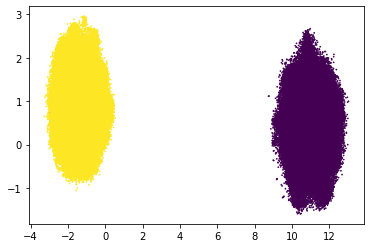

In [17]:
# 4.2 On the edges of each cluster, outliers can be seen:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

We will choose Quantile Transformer to scale the features based on their quantiles and median. This scaling method suits the dataset better since it contains many skewed and bimodal features:

## umap on original data--No PCA

In [18]:
%%time
# 7 seconds
# 5.0 Preprocess again
pipe = make_pipeline(
                     SimpleImputer(strategy="mean"),
                     StandardScaler()
                     )

# 5.1
Xp = pipe.fit_transform(X)

CPU times: user 4.41 s, sys: 202 ms, total: 4.62 s
Wall time: 4.81 s


In [19]:
# 5.2 Sample Xp 
Xp.shape  # (957919, 118)
Xp_sample = Xp[indicies,:]
Xp_sample.shape   # (100000, 118)

(957919, 118)

(100000, 118)

In [20]:
%%time
# 6.0 Fit UMAP to processed data
manifold = umap.UMAP().fit(Xp_sample, y)
X_reduced_2 = manifold.transform(Xp_sample)  # Takes 3minutes

CPU times: user 4min 25s, sys: 4.26 s, total: 4min 29s
Wall time: 2min 41s


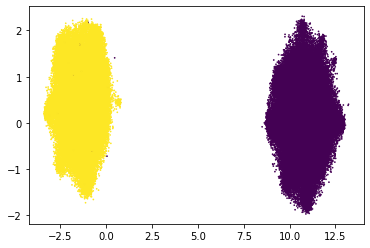

In [21]:
# 6.1 Plot the results
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

Let us deal with outliers using quantile transformers

In [22]:
%%time
# 56 seconds
# 7.0 Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler(),QuantileTransformer() )
Xp = pipe.fit_transform(X)

CPU times: user 42.3 s, sys: 2.3 s, total: 44.6 s
Wall time: 53.3 s


In [23]:
# 7.1 Sample Xp 
Xp.shape  # (957919, 118)
Xp_sample = Xp[indicies,:]
Xp_sample.shape   # (100000, 118)

(957919, 118)

(100000, 118)

In [24]:
%%time
# 7.2 Fit UMAP to processed data
#      Takes 2min
manifold = umap.UMAP().fit(Xp_sample, y)
X_reduced_2 = manifold.transform(Xp_sample)  # Takes 3minutes

CPU times: user 4min 9s, sys: 6.26 s, total: 4min 15s
Wall time: 2min 22s


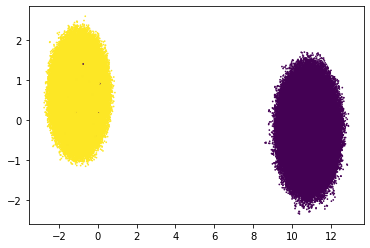

In [25]:
# 7.3 Plot the results
#     This one is more rounded with less outliers
#     compared to earlier one:
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

## PCA after Quantile Transformer

In [27]:
# 8.0 Delete all objects
#      Release memory
del X_reduced_2
del Xp
del X_pca
del Xp_sample
del X_reduced
del X_pca_sample
del tps
gc.collect()

118866

In [39]:
# 9.1 Define a function to take sample:
def take_Sample(X, rand_indicies):
  return X[rand_indicies, :]


In [40]:
# 9.2
indicies = np.random.choice(np.arange(len(X)), size = 100000)
y = y[indicies]

In [41]:
# 9.3 Build a pipeline
#     See how arguments are being passed to functiontransformer:

pipe = make_pipeline(
                     SimpleImputer(strategy="mean"),
                     StandardScaler(),
                     QuantileTransformer(),
                     PCA(n_components=0.90),
                     FunctionTransformer(take_Sample, kw_args = {'rand_indicies' : indicies}),
                     umap.UMAP()
                     )


In [44]:
%%time
# 9.4 Takes 4 minutes
X_umap = pipe.fit_transform(X,y)

CPU times: user 5min 30s, sys: 9.37 s, total: 5min 39s
Wall time: 3min 26s


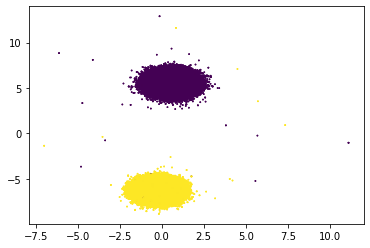

In [46]:
# 9.5 Plot the results
#     This one is more rounded with less outliers
#     compared to earlier one:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=0.5);

# Better visualization with UMAP

This section will analyze the Kaggle TPS May competition data that categorizes ~200k eCommerce listings based on ~75 numeric qualities. Let's import it and take a quick look:

In [47]:
# 14.0 Read data
tps_june = pd.read_csv(datapath + "train_june2021.csv.zip")

In [49]:
# 14.1 Split into X,y
X, y = tps_june.drop("target", axis=1), tps_june[["target"]].values.flatten()

In [50]:
# 14.1 Observe data
X.head().sample(10, axis=1)
X.shape  # (200000, 76)

,feature_58,feature_44,feature_71,feature_67,feature_39,feature_7,feature_53,feature_37,feature_1,feature_38
0,0,0,0,0,0,0,3,11,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,5,3,1,5,0,0
3,2,1,0,4,7,2,0,1,0,0
4,0,0,0,0,5,0,0,2,0,0


(200000, 76)

In [51]:
# 14.2 How many classes?
np.unique(y)

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

The target contains nine classes.

As before, we will scale all features, but this time with a straightforward log transform. Then, we fit the UMAP manifold:

In [52]:
# 15.0 Scale using powertransformer:
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

In [53]:
# 15.1 Encode the target to numeric
y_encoded = pd.factorize(y)
y_encoded
y_encoded = y_encoded[0]

(array([0, 0, 1, ..., 2, 6, 2]),
 array(['Class_6', 'Class_2', 'Class_8', 'Class_3', 'Class_1', 'Class_5',
        'Class_7', 'Class_9', 'Class_4'], dtype=object))

In [54]:
%%time
# 15.2
#  Takes 4 minutes
manifold = umap.UMAP().fit(X, y_encoded)  # 5 minutes

CPU times: user 8min 41s, sys: 13.8 s, total: 8min 55s
Wall time: 5min 17s


After the fit is done, we will import the `umap.plot` package (installed separately) and plot a point cloud:

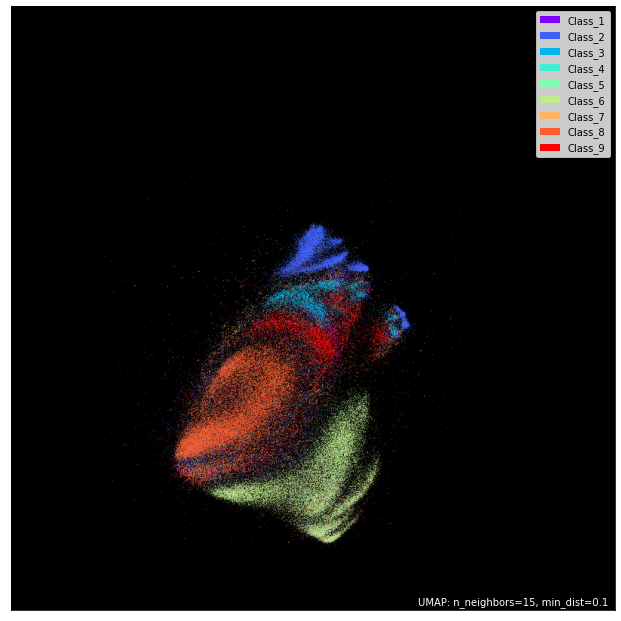

In [55]:
# 16.0
umap.plot.points(manifold, labels=y, theme="fire");

In [ ]:
############ I am done ###################

Doesn't it resemble a nebula from space? We can distinctly see that Class 8 dominates the space and is clustered around the center. Class 6 is also clearly distinguished from the rest. We see half a circle of mixed data points around class 8. Regarding the singleton data points, they may be classified as outliers.

> A note on visualization above - we are simply passing the fitted manifold (not transformed data!) to the `points` function and specifying the labels for color encoding. I have also chosen the `fire` as a dark theme.

You can also create connectivity plots with `umap.plot.connectivity` for diagnostics purposes and to better understand the manifold structure. Do note that creating these plots is time-consuming and computation/memory-heavy.

<p float="left">
  <img src="https://miro.medium.com/max/1250/1*OMXhwgFxgwn5fLEkGrV_Pw.png" width="300" height="300"/>
  <img src="https://miro.medium.com/max/1250/1*rlfn-CugxKhmZ8G7sLJQJQ.png" width="300" height="300"/> 
</p>

You can learn more about UMAP visualizations from [this section](https://umap-learn.readthedocs.io/en/latest/plotting.html) of the documentation.

# Most important parameters of UMAP

The underlying reduction algorithm has many parameters that can significantly impact the manifold and hence, the visuals. The four most important ones are:
- `n_components`
- `n_neighbors`
- `min_dist`
- `metric`

As you might have guessed, `n_components` controls the number of dimensions after the projection. The default is 2 for its ease of visualization. However, for datasets with more than 100 features, 2D may not be enough to preserve the underlying topological structure of the data fully. I recommend trying values between 2-20 at steps of 5 and evaluate different baseline models to see the change in accuracy.

Next, we have `n_neighbors`. It controls the area of the local neighborhood UMAP looks at for each sample when building the manifold. Smaller values narrow the focus to local structure, taking into account peculiarities and small patterns, potentially losing the big picture.

Higher values to `n_neighbors` give more flexibility and allows UMAP to focus on a broader "view" of the data in the corresponding dimension. This, of course, comes at the cost of losing the finer details of the structure. The default value for this parameter is 15.

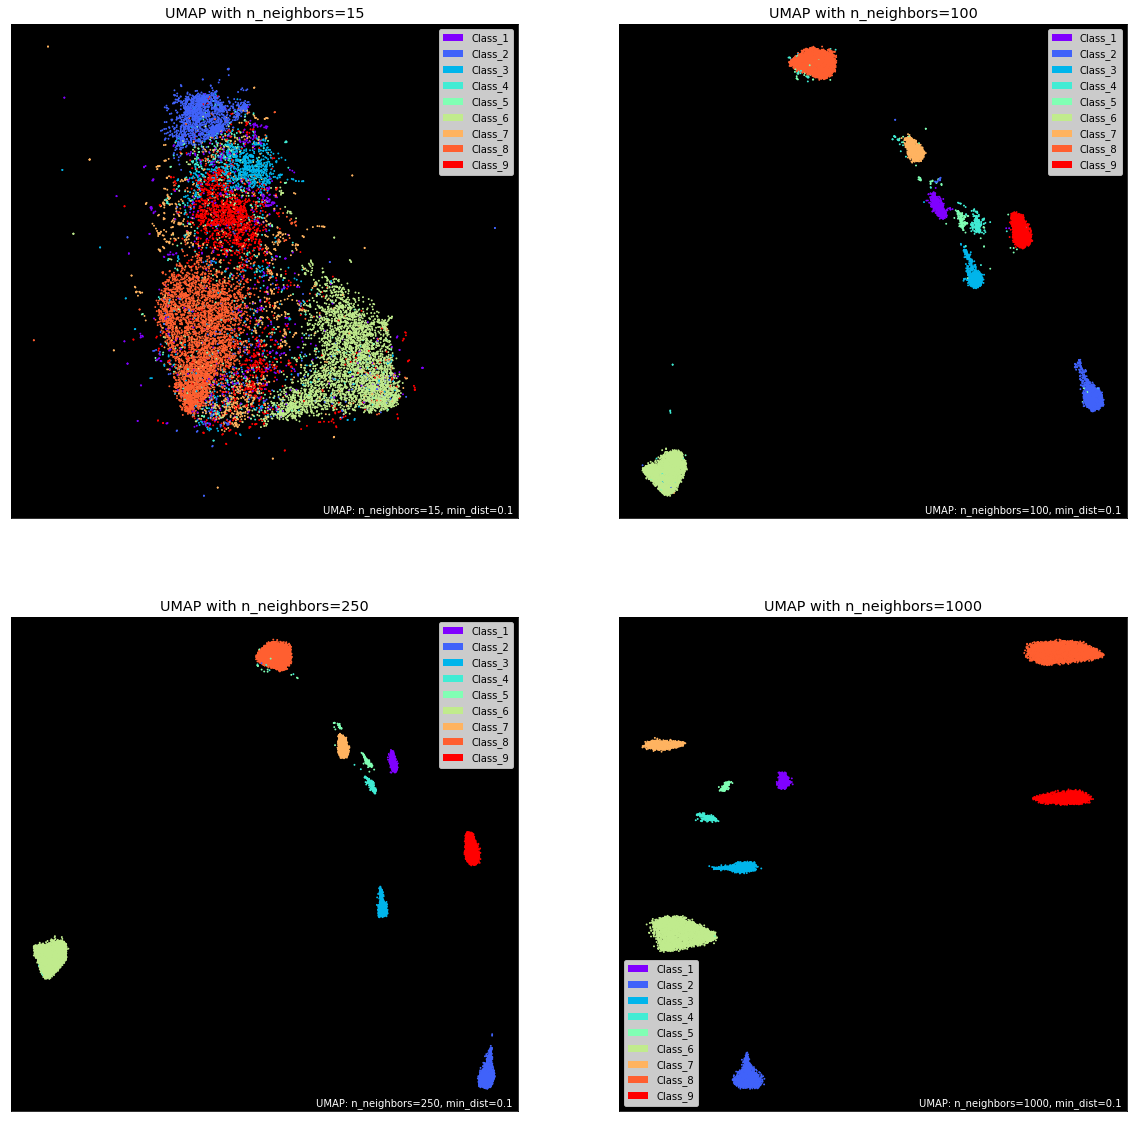

In [ ]:
n_neighbors = [15, 100, 250, 1000]
tps_june = pd.read_csv(datapath + "train_june2021.csv.zip").sample(15000)
X, y = tps_june.drop("target", axis=1), tps_june[["target"]].values.flatten()

# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for ax, n in zip(ax.flatten(), n_neighbors):
    manifold = umap.UMAP(n_neighbors=n, random_state=1121218)
    manifold.fit(X, y_encoded)
    umap.plot.points(manifold, labels=y, ax=ax, theme="fire")
    ax.set_title(f"UMAP with n_neighbors={n}", fontsize="x-large")


fig.savefig("multiple_neighbors.png", dpi=300);

Another critical parameter is `min_dist` which controls the literal distance between data points. You can tweak the default value of 0.1 to control the tightness of distinct point clouds. Lower values will result in clumpier embeddings, allowing you to see individual clusters more easily. This may be useful during clustering. In contrast, values close to 1 give points more breathing room and enable you to see the broader topological structure.

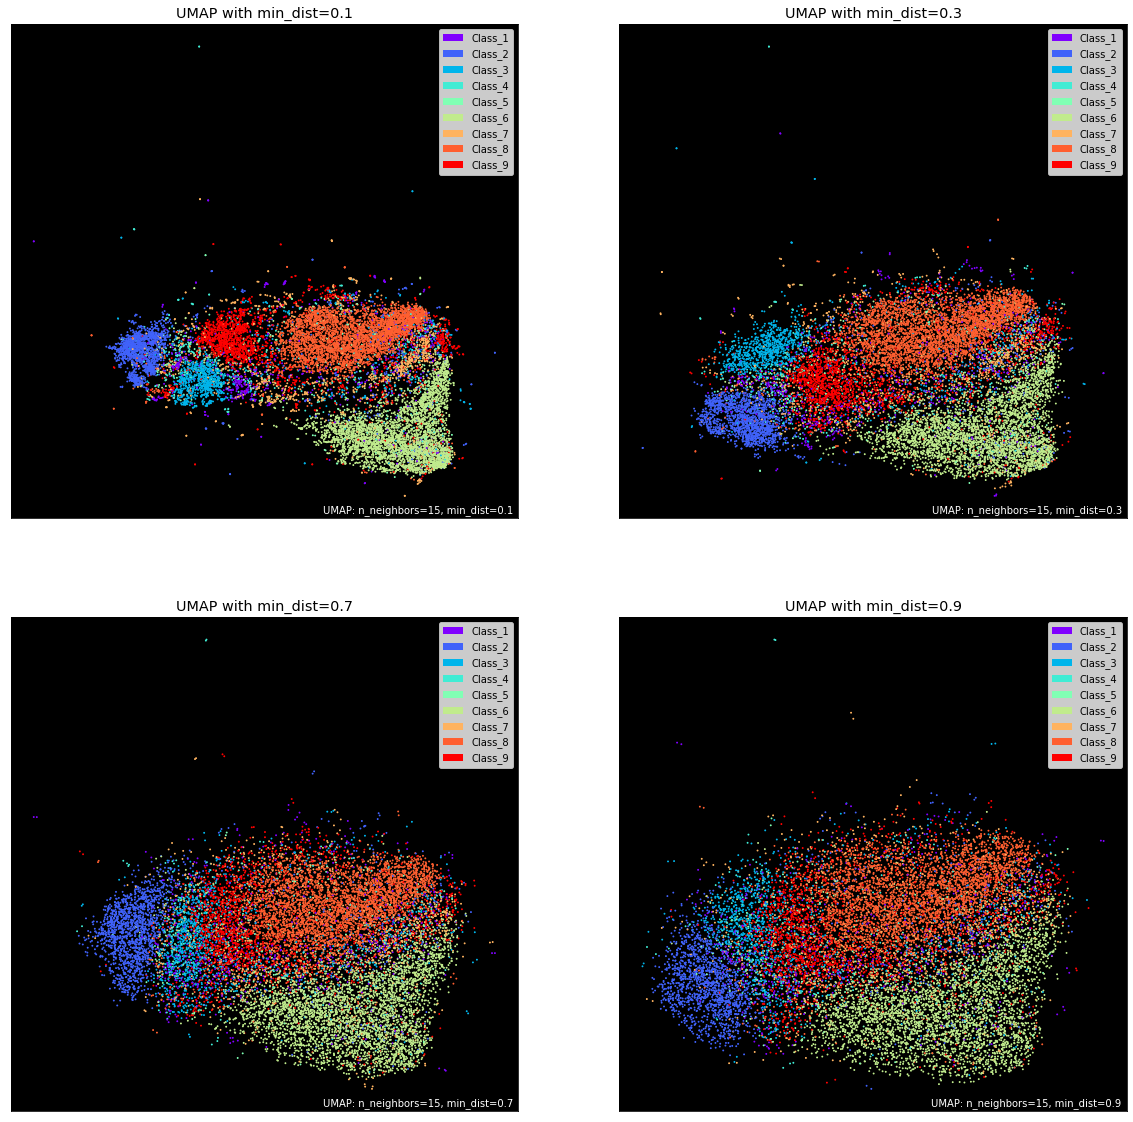

In [ ]:
distances = [0.1, 0.3, 0.7, 0.9]

tps_june = pd.read_csv(datapath + "train_june2021.csv.zip").sample(15000)

X, y = tps_june.drop("target", axis=1), tps_june[["target"]].values.flatten()

# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for ax, n in zip(ax.flatten(), distances):
    manifold = umap.UMAP(min_dist=n, random_state=1121218)
    manifold.fit(X, y_encoded)
    umap.plot.points(manifold, labels=y, ax=ax, theme="fire")
    ax.set_title(f"UMAP with min_dist={n}", fontsize="x-large")


fig.savefig("multiple_distances.png", dpi=300);


`metric` represents the formula to calculate the distance between points. The default is `euclidean` but you can choose among many others, including `manhattan`, `minkowski` and `chebyshev`.

# Best practices of using UMAP

First consideration while using UMAP is the RAM consumption. Under the hood, UMAP consumes a lot of memory, especially during fitting and creating diagrams like connectivity plots. I suggest running UMAP on a machine with at least 16GB of RAM.

For example, even the 200k-row dataset in the plotting section consumed ~18GB of RAM when creating the connectivity plot. The documentation suggests setting `low_memory` to True as a possible fix. Additionally, I recommend reducing the memory usage of the dataset by casting each column to the smallest subtype possible using NumPy. I have discussed dealing with out-of-memory issues at length in a previous article ([link](https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd?source=your_stories_page-------------------------------------)).

Also, don't forget to transform/scale numerical features as they tend to have different scales by default. I suggest QuantileTransformer for crazy distributions like bimodals, trimodals, etc. PowerTransformer works best for skewed features. Whichever transformer you choose, the goal is always to make features as normally distributed as possible.

# Summary

Today, we have covered the basics of UMAP and learned only a thin slice of what it can do. For further reading, I suggest checking out the documentation of the package. There, you will see different use cases of UMAP and how it is used by tech giants like Google in various projects.
There are also dedicated sections for comparing UMAP to other dimensionality reduction algorithms. For a math enthusiast, you can also read how UMAP works and proofs of its formulas. Thank you for reading!